# 1D Spectrum Analysis HAP-fr


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import astropy.units as u
from astropy.coordinates import SkyCoord,Angle
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion, RectangleSkyRegion

from gammapy.detect import compute_lima_on_off_image
from gammapy.data import DataStore
from gammapy.irf import make_mean_psf
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.cube import (
    MapDatasetMaker,
    PSFKernel,
    MapDataset,
    RingBackgroundMaker,
    SafeMaskMaker,
    #RingBackgroundEstimator,
)
from gammapy.modeling import Datasets
from gammapy.modeling.models import (
    SkyModel,
    BackgroundModel,
    PowerLawSpectralModel,
    PowerLaw2SpectralModel,
    PointSpatialModel,
    ExpCutoffPowerLawSpectralModel,
    SkyDiffuseCube,
    TemplateSpatialModel,
    
)

from gammapy.spectrum import (
    SpectrumDatasetMaker,
    SpectrumDatasetOnOff,
    SpectrumDataset,
    FluxPointsEstimator,
    FluxPointsDataset,
    ReflectedRegionsBackgroundMaker,
    plot_spectrum_datasets_off_regions,
)
from gammapy.modeling import Fit
from astropy.time import Time

src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

import gammapy
gammapy.__version__


'0.15'

In [79]:
from pathlib import Path

path = Path("../../../../gammapy_data/GC_variability2020/hap-fr/1Danalysis")
path.mkdir(exist_ok=True)

pathm = path/"mapdatasets1D"
pathm.mkdir(exist_ok=True)

path1 = path/"spectra"
path1.mkdir(exist_ok=True)

# Collecting data and sorting observations

In [50]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/ash_stereo_Prod17_Calib0834_thsq64")
#obs_ids = [23523, 23526, 23559, 23592]
#observations = datastore.get_observations(obs_ids)

In [52]:
# Sky region selection : observation pointing within this region will be selected 
#(this can be redundant with maximum offset selection, but using the max_offset should be prefered)

from astropy.coordinates import Angle

184.55745 -05.78436

selection = dict(type='sky_circle', frame='galactic',
                 lon=Angle(184.56, 'deg'),
                 lat=Angle(-05.78, 'deg'),
                 radius=Angle(1.0, 'deg'),
                 border=Angle(0, 'deg'))


# selecting the admitted range of zenithal angle, such selection can be done for any column of the obs_table
selectionZEN = dict(type='par_box', variable='ZEN_PNT', value_range=Angle([0., 50.], 'deg'))

obs_table = data_store.obs_table.select_observations(selection)
obs_table = obs_table.select_observations(selectionZEN)

In [58]:
# Removing observations lacking IRFs (effective area, energy dispersion, point spread function and background model)

ids = obs_table["OBS_ID"].tolist()
observations = data_store.get_observations(ids, skip_missing=True)

for obs in observations:
    try:
        obs.aeff
        obs.edisp
        obs.psf
        obs.bkg
            
    except:
        ids.remove(obs.obs_id)
        print("Removed observations : " + str(obs.obs_id))
        
observations = data_store.get_observations(ids, skip_missing=True)
obs_table = obs_table.select_obs_id(ids)

Removed observations : 154410
Removed observations : 154590
Removed observations : 154591
Removed observations : 127956
Removed observations : 144012
Removed observations : 154377
Removed observations : 154378


 d'après hap-hd
 
HESS1 des obs 20191 à 82904

HESS2 des obs 85237 à 123634

HESS1U des obs 129419 à 153842


In [59]:
#time intervals used for selection

t2004  = dict(type='time_box', time_range= Time(['2004-01-01T00:00:00', '2004-12-31T23:59:59']))
t2005  = dict(type='time_box', time_range= Time(['2005-01-01T00:00:00', '2005-12-31T23:59:59']))
t2006  = dict(type='time_box', time_range= Time(['2006-01-01T00:00:00', '2006-12-31T23:59:59']))
t2007  = dict(type='time_box', time_range= Time(['2007-01-01T00:00:00', '2007-12-31T23:59:59']))
t2008  = dict(type='time_box', time_range= Time(['2008-01-01T00:00:00', '2008-12-31T23:59:59']))
t2009  = dict(type='time_box', time_range= Time(['2009-01-01T00:00:00', '2009-12-31T23:59:59']))
t2010  = dict(type='time_box', time_range= Time(['2010-01-01T00:00:00', '2010-12-31T23:59:59']))
t2011  = dict(type='time_box', time_range= Time(['2011-01-01T00:00:00', '2011-12-31T23:59:59']))
t2012  = dict(type='time_box', time_range= Time(['2012-01-01T00:00:00', '2012-12-31T23:59:59']))
t2013  = dict(type='time_box', time_range= Time(['2013-01-01T00:00:00', '2013-12-31T23:59:59']))
t2014  = dict(type='time_box', time_range= Time(['2014-01-01T00:00:00', '2014-12-31T23:59:59']))
t2015  = dict(type='time_box', time_range= Time(['2015-01-01T00:00:00', '2015-12-31T23:59:59']))
t2016  = dict(type='time_box', time_range= Time(['2016-01-01T00:00:00', '2016-12-31T23:59:59']))
t2017  = dict(type='time_box', time_range= Time(['2017-01-01T00:00:00', '2017-12-31T23:59:59']))
t2018  = dict(type='time_box', time_range= Time(['2018-01-01T00:00:00', '2018-12-31T23:59:59']))
t2019  = dict(type='time_box', time_range= Time(['2019-01-01T00:00:00', '2019-12-31T23:59:59']))

In [60]:
year_intervals = { 2004 : t2004, 2005 : t2005, 2006 : t2006, 2007 : t2007,
                      2008 : t2008, 2009 : t2009, 2010 : t2010, 2011 : t2011,
                      2012 : t2012, 2013 : t2013, 2014 : t2014, 2015 : t2015,
                      2016 : t2016, 2017 : t2017, 2018 : t2018, 2019 : t2019}

yearly_obs = dict()

for year in range(2004,2020) :
    
    obs_table_year = obs_table.select_observations(year_intervals[year])
    ids = obs_table_year["OBS_ID"].tolist()
    observations_year = data_store.get_observations(ids, skip_missing=True)
    yearly_obs[year] = observations_year

## Setting the parameters of the analysis

In [61]:
# Defining the "on" region over which the spectrum will be computed

target_position = SkyCoord(ra=83.63, dec=22.01, unit="deg", frame="icrs")
on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

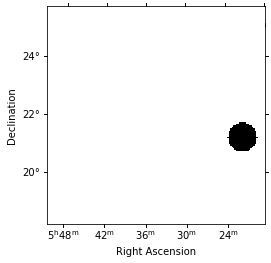

In [62]:


exclusion_region = CircleSkyRegion(
    center=SkyCoord(183.604, -8.708, unit="deg", frame="galactic"),
    radius=0.5 * u.deg,
)

skydir = target_position.galactic
exclusion_mask = Map.create(
    npix=(150, 150), binsz=0.05, skydir=skydir, proj="TAN", coordsys="CEL"
)

mask = exclusion_mask.geom.region_mask([exclusion_region], inside=False)
exclusion_mask.data = mask
exclusion_mask.plot();



In [98]:

e_reco = np.logspace(-1, np.log10(40), 40) * u.TeV
e_true = np.logspace(np.log10(0.05), 2, 200) * u.TeV
dataset_empty = SpectrumDataset.create(
    e_reco=e_reco, e_true=e_true, region=on_region
)

In [99]:
dataset_maker = SpectrumDatasetMaker(
    containment_correction=False, selection=["counts", "aeff", "edisp"]
)
bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)

safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

In [100]:
len(observations)

217

## Constructing the datasets

In [101]:
%%time

# constructing datasets for every year of observations
datasets = []

year_datasets = dict()

datasetsHESS1 = []

datasetsHESS2 = []

datasetsHESS1U = []


for year in range(2004,2020):
    year_datasets[year] = []
    for obs in yearly_obs[year]:
        dataset = dataset_maker.run(dataset_empty, obs)
        dataset_on_off = bkg_maker.run(dataset, obs)
        dataset_on_off = safe_mask_masker.run(dataset_on_off, obs)
        
        # s'il n'y a pas de coups dans la région off, on ne conserve pas l'observation
        if dataset_on_off.counts_off != None:
            year_datasets[year].append(dataset_on_off)
            datasets.append(dataset_on_off)
            
            if (obs.obs_id > 20190 and obs.obs_id < 82905):
                datasetsHESS1.append(dataset_on_off)
            if (obs.obs_id > 85236 and obs.obs_id < 123635):
                datasetsHESS2.append(dataset_on_off)                
            if (obs.obs_id > 129418 and obs.obs_id < 153843):
                datasetsHESS1U.append(dataset_on_off)


CPU times: user 1min 28s, sys: 229 ms, total: 1min 28s
Wall time: 1min 29s


# Analysis

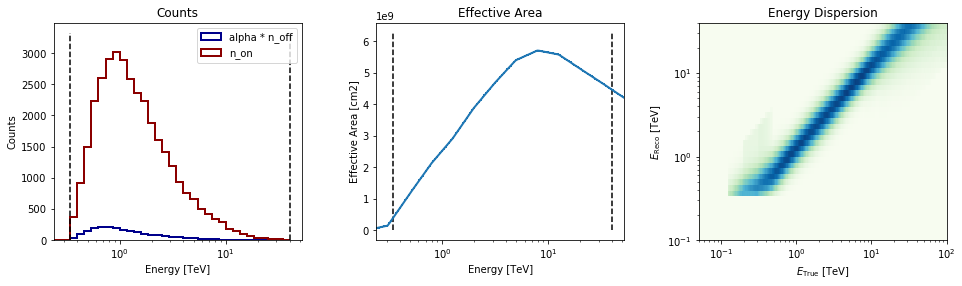

In [102]:
datasets_stacked = Datasets(datasets).stack_reduce()
datasets_stacked.peek()
#plt.savefig(path1/"stacked_peek.pdf")

## Fitting without stacking

In [103]:
spectral_model = ExpCutoffPowerLawSpectralModel(index=2, amplitude=3e-12 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV , lambda_= 1/(10*u.TeV) , alpha= 1)

#spectral_model = PowerLawSpectralModel(index=2, amplitude=3e-12 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV )

In [104]:
model_joint = SkyModel(spectral_model=spectral_model)

#maskfit = datasets[0].counts.energy_mask(0.7*u.TeV, 40*u.TeV)
# pas sur de ce que ça fait

for dataset in datasets:
    dataset.models = model_joint
    dataset.mask_fit = None

fit_joint = Fit(datasets)
result_joint = fit_joint.run()

# we make a copy here to compare it later
model_best_joint = model_joint.copy()
model_best_joint.spectral_model.parameters.covariance = (
    result_joint.parameters.covariance
)

## Fitting after stacking

In [105]:
model_stack = SkyModel(spectral_model=spectral_model)

#maskfit = datasets_stacked.counts.energy_mask(0.7*u.TeV, 40*u.TeV)

datasets_stacked.models = model_stack
datasets_stacked.mask_fit = None

stacked_fit = Fit([datasets_stacked])
result_stacked = stacked_fit.run()

# make a copy to compare later
model_best_stacked = model_stack.copy()
model_best_stacked.spectral_model.parameters.covariance = (
    result_stacked.parameters.covariance
)

## Comparing the two fits

In [106]:
model_best_joint.parameters.to_table()

name,value,error,unit,min,max,frozen
str9,float64,float64,str14,float64,float64,bool
index,2.115e+00,1.723e-02,,nan,nan,False
amplitude,2.144e-11,2.685e-13,cm-2 s-1 TeV-1,nan,nan,False
reference,1.000e+00,0.000e+00,TeV,nan,nan,True
lambda_,1.416e-01,8.043e-03,TeV-1,nan,nan,False
alpha,1.000e+00,0.000e+00,,nan,nan,True


In [107]:
model_best_stacked.parameters.to_table()

name,value,error,unit,min,max,frozen
str9,float64,float64,str14,float64,float64,bool
index,2.133e+00,1.598e-02,,nan,nan,False
amplitude,2.116e-11,2.406e-13,cm-2 s-1 TeV-1,nan,nan,False
reference,1.000e+00,0.000e+00,TeV,nan,nan,True
lambda_,1.308e-01,7.019e-03,TeV-1,nan,nan,False
alpha,1.000e+00,0.000e+00,,nan,nan,True


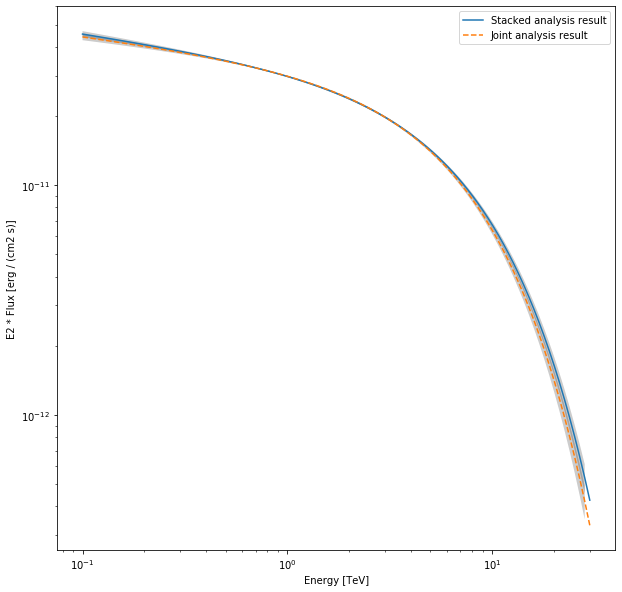

In [108]:
plt.figure(figsize=(10,10))
plot_kwargs = {
    "energy_range": [0.1, 30] * u.TeV,
    "energy_power": 2,
    "flux_unit": "erg-1 cm-2 s-1",
}

# plot stacked model
model_best_stacked.spectral_model.plot(
    **plot_kwargs, label="Stacked analysis result"
)
model_best_stacked.spectral_model.plot_error(**plot_kwargs)

# plot joint model
model_best_joint.spectral_model.plot(
    **plot_kwargs, label="Joint analysis result", ls="--"
)
model_best_joint.spectral_model.plot_error(**plot_kwargs)

plt.legend()
#plt.savefig(path1/"models_total.pdf")

Text(0.5, 1.0, 'Total spectrum')

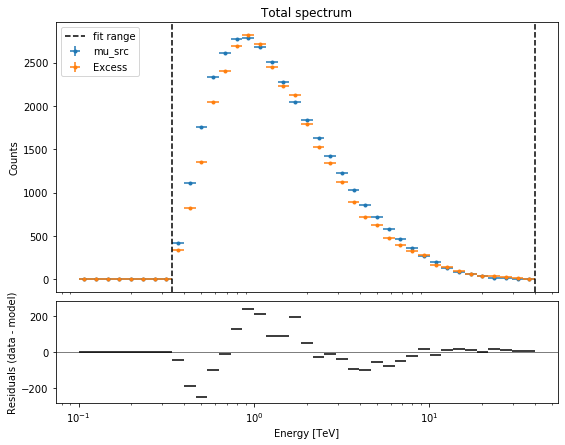

In [125]:
plt.figure(figsize=(9, 7))
ax_spectrum, ax_residual = datasets_stacked.plot_fit()

ax_spectrum.set_title("Total spectrum")
#ax_spectrum.set_ylim(0.1, 40)
#plt.savefig("totalspectrum.pdf")

In [126]:
datasets_stacked.info_dict()

{'name': '18870',
 'livetime': <Quantity 326305.2848196 s>,
 'a_on': 1.0,
 'n_on': 34229,
 'n_off': 32646,
 'a_off': 15.251783657070657,
 'alpha': 0.06556610180714205,
 'background': 2140.4709595959594,
 'excess': 32088.529040404042,
 'significance': 319.92227940267094,
 'background_rate': <Quantity 0.00655972 1 / s>,
 'gamma_rate': <Quantity 0.09833898 1 / s>}

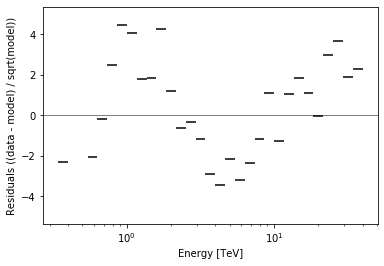

In [110]:
datasets_stacked.plot_residuals(method='diff/sqrt(model)')

## Computing Flux points

In [79]:
e_min, e_max = 0.7, 30
e_edges = np.logspace(np.log10(e_min), np.log10(e_max), 11) * u.TeV

In [80]:
fpe = FluxPointsEstimator(datasets=[datasets_stacked], e_edges=e_edges)
flux_points = fpe.run()

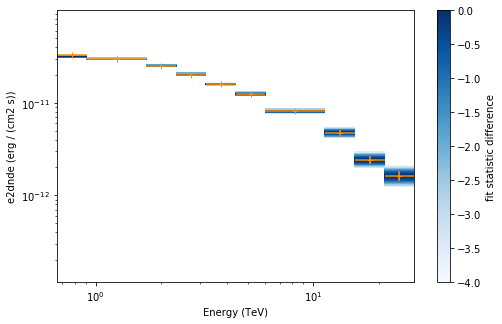

In [81]:

plt.figure(figsize=(8, 5))
flux_points.table["is_ul"] = flux_points.table["ts"] < 4
ax = flux_points.plot(
    energy_power=2, flux_unit="erg-1 cm-2 s-1", color="darkorange"
)
flux_points.to_sed_type("e2dnde").plot_ts_profiles(ax=ax)



In [82]:
flux_points_dataset = FluxPointsDataset(
    data=flux_points, models=model_best_joint
)

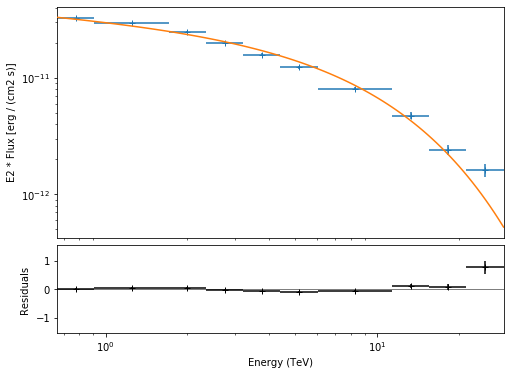

In [83]:
plt.figure(figsize=(8, 6))
flux_points_dataset.peek();

## Studying HESS1 HESS2 and HESS1U separately

Text(0.5, 1.0, 'HESS1 spectrum')

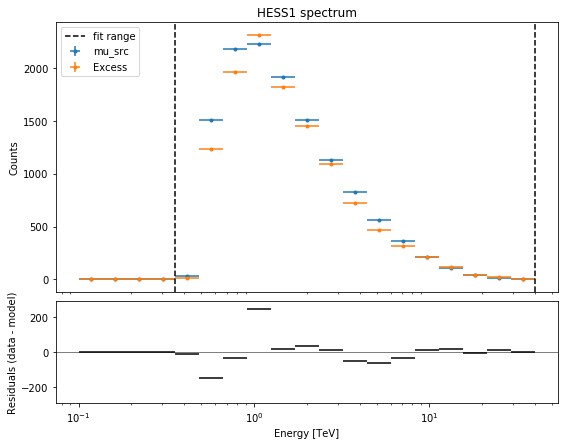

In [85]:
datasets_stacked = Datasets(datasetsHESS1).stack_reduce()

model_stack = SkyModel(spectral_model=spectral_model)

datasets_stacked.models = model_stack # quelle différence entre model et models ?
#datasets_stacked.mask_fit = maskfit

stacked_fit = Fit([datasets_stacked])
result_stacked = stacked_fit.run()

# make a copy to compare later
model_best_stacked = model_stack.copy()
model_best_stacked.spectral_model.parameters.covariance = (
    result_stacked.parameters.covariance
)

#model_best_stacked.parameters.to_table()

plt.figure(figsize=(9, 7))
ax_spectrum, ax_residual = datasets_stacked.plot_fit()
ax_spectrum.set_title("HESS1 spectrum")
#plt.savefig(path1/'HESS1spectrum.pdf')

Text(0.5, 1.0, 'HESS2 spectrum')

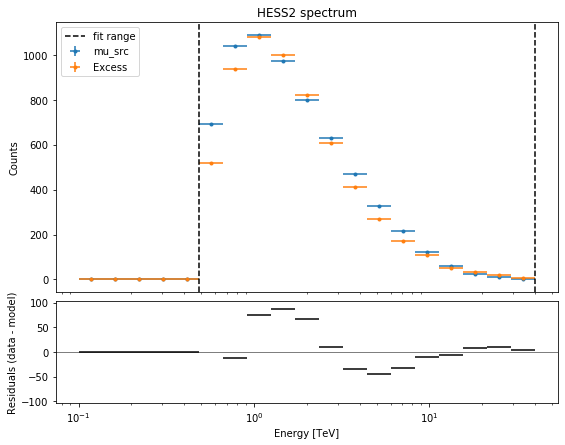

In [87]:
datasets_stacked = Datasets(datasetsHESS2).stack_reduce()


model_stack = SkyModel(spectral_model=spectral_model)

datasets_stacked.models = model_stack # quelle différence entre model et models ?
#datasets_stacked.mask_fit = maskfit

stacked_fit = Fit([datasets_stacked])
result_stacked = stacked_fit.run()

# make a copy to compare later
model_best_stacked = model_stack.copy()
model_best_stacked.spectral_model.parameters.covariance = (
    result_stacked.parameters.covariance
)

#model_best_stacked.parameters.to_table()

plt.figure(figsize=(9, 7))
ax_spectrum, ax_residual = datasets_stacked.plot_fit()
ax_spectrum.set_title("HESS2 spectrum")
#plt.savefig(path1/'HESS2spectrum.pdf')

Text(0.5, 1.0, 'HESS1U spectrum')

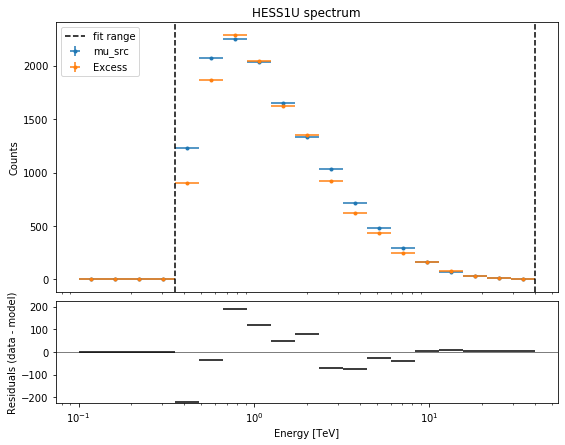

In [88]:
datasets_stacked = Datasets(datasetsHESS1U).stack_reduce()

model_stack = SkyModel(spectral_model=spectral_model)

datasets_stacked.models = model_stack # quelle différence entre model et models ?
#datasets_stacked.mask_fit = maskfit

stacked_fit = Fit([datasets_stacked])
result_stacked = stacked_fit.run()

# make a copy to compare later
model_best_stacked = model_stack.copy()
model_best_stacked.spectral_model.parameters.covariance = (
    result_stacked.parameters.covariance
)

#model_best_stacked.parameters.to_table()

plt.figure(figsize=(9, 7))
ax_spectrum, ax_residual = datasets_stacked.plot_fit()
ax_spectrum.set_title("HESS1U spectrum")
#plt.savefig(path1/'HESS1Uspectrum.pdf')

## Studying each each year separately

ValueError: Stacking impossible: all Datasets contained are not of a unique type.

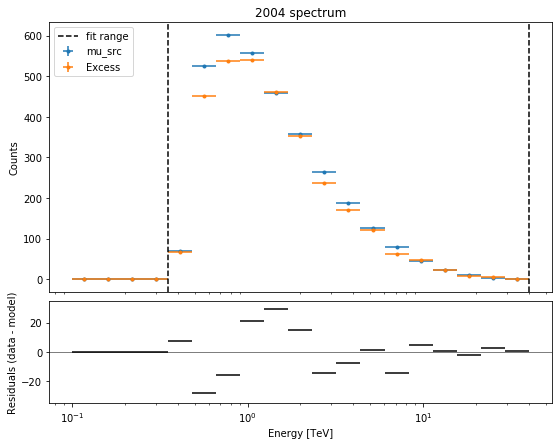

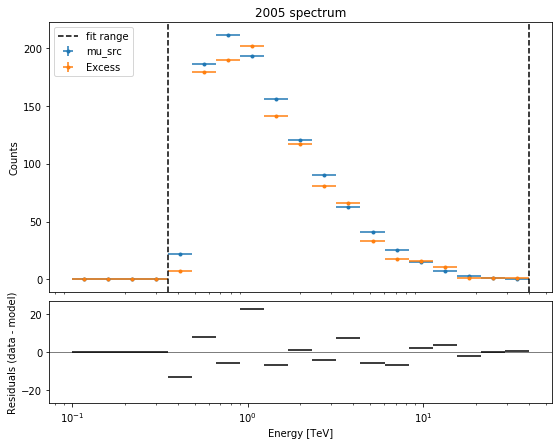

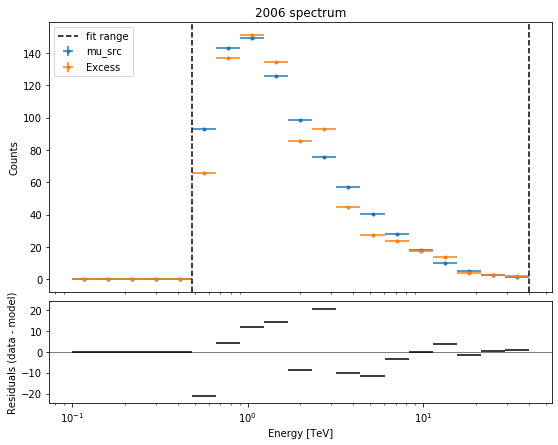

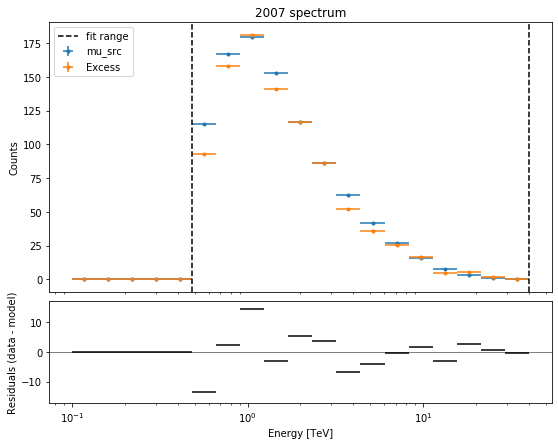

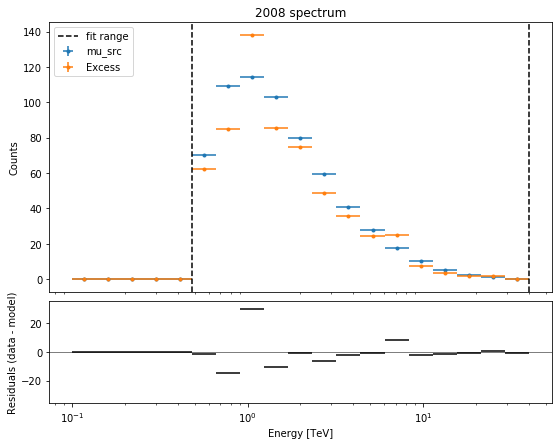

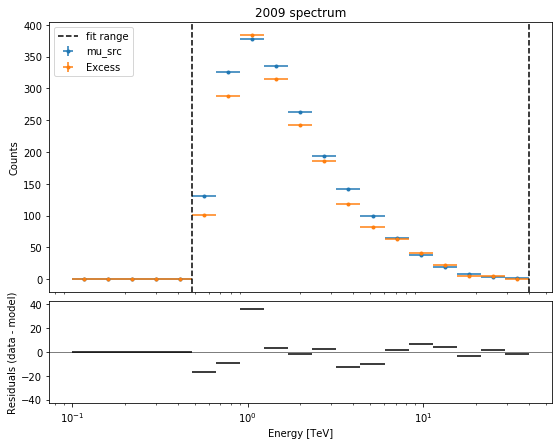

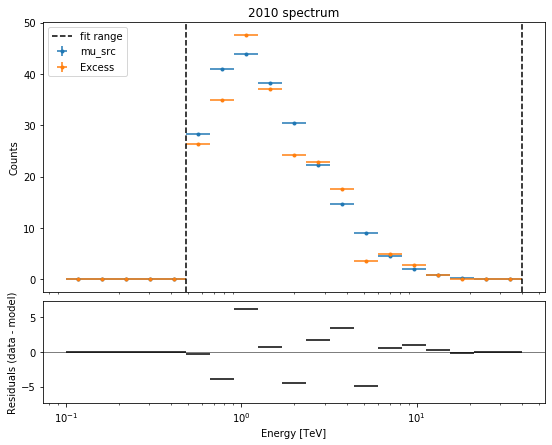

In [89]:
for year in range(2004,2020):
    
    datasets_stacked = Datasets(year_datasets[year]).stack_reduce()


    model_stack = SkyModel(spectral_model=spectral_model)

    datasets_stacked.models = model_stack # quelle différence entre model et models ?
    #datasets_stacked.mask_fit = maskfit

    stacked_fit = Fit([datasets_stacked])
    result_stacked = stacked_fit.run()

    # make a copy to compare later
    model_best_stacked = model_stack.copy()
    model_best_stacked.spectral_model.parameters.covariance = (
        result_stacked.parameters.covariance
    )

    model_best_stacked.parameters.to_table()

    plt.figure(figsize=(9, 7))
    ax_spectrum, ax_residual = datasets_stacked.plot_fit()
    ax_spectrum.set_title(str(year) + " spectrum")
    name = str(year) + "spectrum.pdf"
    #plt.savefig(path1/name)